# Transformer lab 
# Part 1/2: Using transformer for classification
---
- The goal of this notebook is to study the VIT (visual transformer) model, with a diagram provided below. 

<center width="100%"><img src="img/VIT-architecture.png" alt="main diagram of a VIT model" width="600px"></center>

Transformers for Computer Vision. Since the introduction of transformers in vision in 2021 with the seminal paper of [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy), there have been a huge amount of follow-up works showing that CNNs might not be optimal architecture for Computer Vision anymore. But how do Vision Transformers work exactly, and what benefits and drawbacks do they offer in contrast to CNNs? This lab with investigate these questions by implementing a Vision Transformer based on the pytorch library and train it on the popular, small dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) (60,000 images of size 32x32, 10 classes, with 6,000 images per class). We will compare these results to the convolutional ResNet CNN architecture. 


This lab is heavily inspired by the excellent AI-focused website of the University of Amsterdam, designed for master's students. Additional resources that may interest you can be found on the [UVA website](https://uvadlc-notebooks.readthedocs.io/en/latest/). Feel free to explore it and stay curious!

This lab is based on [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/). PyTorch Lightning is a lightweight, high-level wrapper for PyTorch that simplifies the training process by handling common boilerplate code, such as training loops, checkpointing, and logging, allowing researchers to focus on model development. It promotes cleaner, modular code, making it easier to scale experiments from a single GPU to multiple GPUs or even entire clusters with minimal changes.

```
Run the following cell to install Pytorch Lightning on your conda environnement
```

In [1]:
!conda install -n monai-dev "pytorch-lightning>1.4" -y

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.



[Seaborn library](https://seaborn.pydata.org/) will be used in this lab. Seaborn is a Python library built on top of Matplotlib that simplifies the creation of visually appealing and informative statistical graphics, such as heatmaps, violin plots, and pair plots. It provides high-level functions for complex visualizations and integrates seamlessly with pandas for easy handling of DataFrames.

```
Run the following cell to install the Seaborn library on your conda environnement
```

In [2]:
!conda install -n monai-dev seaborn -y

Channels:
 - conda-forge
 - pytorch
Platform: linux-64
Solving environment: done

# All requested packages already installed.



```
Run the following cell to import the necessary libraries to work with the data and PyTorch.
```

In [3]:
### Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image
### seaborn
import seaborn as sns
sns.reset_orig()
### Tqdm (Processing bar)
from tqdm.notebook import tqdm
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from  torch.utils.data import random_split, DataLoader
import torch.optim as optim
### Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
### PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
### Matplotlib
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2.0

# Import tensorboard
%load_ext tensorboard

# Print main the version of the main libraries
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch-Ligthning version: {pl.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")


PyTorch version: 2.5.1
PyTorch-Ligthning version: 2.4.0
Torchvision version: 0.20.1
Numpy version: 1.26.4


```
Run the following cell to setup some configuration properties
```

In [4]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
pl.seed_everything(42)  # Setting the seed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Find on which device to perform the different computation
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Seed set to 42


Device: cuda:0


---
## Load and Visualize the Data

Downloading may take a few moments, and you should see your progress as the data is loading.

```
Run the following cell to download and create Dataset from pytorch
```

In [5]:
# how many samples per batch to load
batch_size = 128

# Path to store MedNIST dataset
data_dir = "./data/cifar-10-batches-py"

# Checks if data has already been downloaded
download = not os.path.exists(data_dir)

# define the different transforms applied to the image before the generation of the dataset
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])

# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])

# Load dataset without reloading if data already exists
train_dataset = CIFAR10(root='data', train=True, transform=train_transform, download=download)
val_dataset = CIFAR10(root='data', train=True, transform=test_transform, download=download)
test_data = CIFAR10(root='data', train=False, transform=test_transform, download=download)

# split the train_data into a train (90%) and valid (10%) subdataset
pl.seed_everything(42)
train_data, _ = random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_data = random_split(val_dataset, [45000, 5000])

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)

# display the size of the different datasets 
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

Seed set to 42
Seed set to 42


Training dataset size: 45000
Validation dataset size: 5000
Test dataset size: 10000


### Visualize a Batch of Training Data

It's always important to check the accuracy of the data before going any further.

```
Run the cell below to display a subset of the training dataset and the size of a batch
```

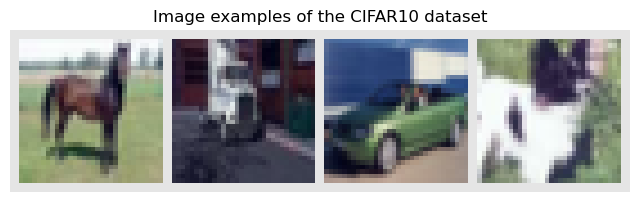

In [6]:
NUM_IMAGES = 4

# creates a CIFAR_images tensor containing the first 4 images of the dataset
CIFAR_images = torch.stack([val_data[idx][0] for idx in range(NUM_IMAGES)], dim=0)

# creates an image grid to display multiple images in a single figure
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)

# permute the dimensions for each tensor so that the order of the dimensions becomes (H, W, C)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

---
## Definiton of the [VIT network model](https://openreview.net/pdf?id=YicbFdNTTy)

Vision Transformer (ViT) is a model for image classification that views images as sequences of smaller patches. As a preprocessing step, an image is split into patches, generally of size $16\times 16$. Each of these patches is considered a 'token' and projected into a feature space. By adding positional encodings and a class token, a Transformer can be trained for classification. In this lab, we will walk step by step through the Vision Transformer, and implement all parts by ourselves. A GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="img/ViT-animation.gif" width="600px"></center> 

### From an image to a sequence of patches

We will first implement the image preprocessing step, where an image of size $N\times N$ is split into a sequence of $(N/M)^2$ patches, each of size $M\times M$.


```
Run the cell below to define a function generate the sequence of patches from an input image.
```

In [7]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

Let's take a look at how that works for our CIFAR examples above. 

```
Run the cell below to display the set of patches generated from a given image
```

torch.Size([4, 64, 3, 4, 4])


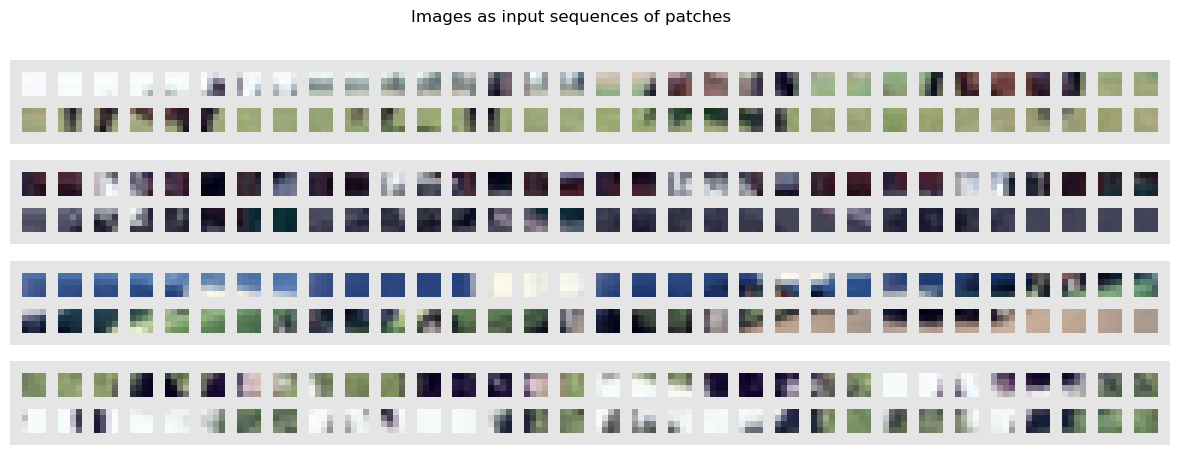

In [8]:
patch_size = 4

img_patches = img_to_patch(CIFAR_images, patch_size=patch_size, flatten_channels=False)
print(img_patches.size())

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(15,5))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=32, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

For reference, the images in the CIFAR-10 dataset are of size $32 \times 32$.

- <span style="color:red">What patch size was chosen?</span>
- <span style="color:red">How many patches are then created per image? Find this value through calculation.</span>

### Definition of the encoder block

We will now define the encoder block that we studied in this course, and whose architecture is given below:

<center width="100%"><img src="img/transformer-encoder.png" width="900px"></center> 

The MLP part is detailed below:

<center width="100%"><img src="img/mlp.png" width="700px"></center> 

We will define the transformer block by using the PyTorch module `MultiheadAttention` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html?highlight=multihead#torch.nn.MultiheadAttention))

```
Run the cell below to define the Attention block class
```

In [9]:
class AttentionBlock(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network 
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, 
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
        
    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

- <span style="color:red">Analyze the code and relate it to the architecture shown in the diagram above. </span>

### Definition of the VIT architecture

The implementation of the full VIT requires the following element:

* A **linear projection** layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each $M\times M$ patch independently as input.
* A **classification token** that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.
* Learnable **positional encodings** that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.
* An **MLP head** that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.

<center width="100%"><img src="img/VIT-architecture.png" width="600px"></center> 

```
Run the cell below to create the VIT class
```

In [10]:
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and 
                      on the input encoding
        """
        super().__init__()
        
        self.patch_size = patch_size
        
        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
    
    
    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        
        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

- <span style="color:red">Analyze the code and relate it to the architecture shown in the diagram above.</span>
- <span style="color:red">Where and how positional embedding is defined?</span>
- <span style="color:red">Where is defined the class token and how it is used to make the final classification?</span>

### Pytorch Lightning module

PyTorch Lightning simplifies the training process by abstracting away boilerplate code, allowing you to focus on the core logic of your model while handling tasks like GPU management, logging, and checkpointing automatically. It also promotes reproducibility and scalability, making it easier to transition from research to production with minimal code changes.

We will thus structure everything into a PyTorch Lightning Module. We use `torch.optim.AdamW` as the optimizer, which is Adam with a corrected weight decay implementation.

```
Run the cell below to create the Pytorch Lightning module of the VIT model
```

In [11]:
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

- <span style="color:red">Analyze the code and try to understand what the PyTorch Lightning module brings</span>

---
## Training of the VIT network

Commonly, Vision Transformers are applied to large-scale image classification benchmarks such as ImageNet to leverage their full potential. However, here we take a step back and ask: can Vision Transformer also succeed on classical, small benchmarks such as CIFAR10? To find this out, we trained a Vision Transformer from scratch on the CIFAR10 dataset. It took about an hour to complete this training for 180 epochs. We have saved the pre-trained weights for this lab. However, if you're curious, you can comment out the corresponding line in the code to run the training yourself outside of this lab.

```
Run the cell below to first create a training function for our PyTorch Lightning module. 
```


In [12]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT_from_scratch"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT_from_scratch.ckpt")
    print(pretrained_filename)
    if os.path.isfile(pretrained_filename):
        print("Here 1")
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        print("Here 2")
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, valid_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, valid_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

Now, we can already start training our model. As seen in our implementation, we have a couple of hyperparameters that we have to set. When creating this notebook, we have performed a small grid search over hyperparameters and listed the best hyperparameters in the cell below. Nevertheless, it is worth discussing the influence that each hyperparameter has, and what intuition we have for choosing its value.

First, let's consider the patch size. The smaller we make the patches, the longer the input sequences to the Transformer become. While in general, this allows the Transformer to model more complex functions, it requires a longer computation time due to its quadratic memory usage in the attention layer. Furthermore, small patches can make the task more difficult since the Transformer has to learn which patches are close-by, and which are far away. We experimented with patch sizes of 2, 4, and 8 which gives us the input sequence lengths of 256, 64, and 16 respectively. We found 4 to result in the best performance and hence pick it below. 

Next, the embedding and hidden dimensionality have a similar impact on a Transformer as to an MLP. The larger the sizes, the more complex the model becomes, and the longer it takes to train. In Transformers, however, we have one more aspect to consider: the query-key sizes in the Multi-Head Attention layers. Each key has the feature dimensionality of `embed_dim/num_heads`. Considering that we have an input sequence length of 64, a minimum reasonable size for the key vectors is 16 or 32. Lower dimensionalities can restrain the possible attention maps too much. We observed that more than 8 heads are not necessary for the Transformer, and therefore pick an embedding dimensionality of `256`. The hidden dimensionality in the feed-forward networks is usually 2-4x larger than the embedding dimensionality, and thus we pick `512`. 

Finally, the learning rate for Transformers is usually relatively small, and in papers, a common value to use is 3e-5. However, since we work with a smaller dataset and have a potentially easier task, we found that we are able to increase the learning rate to 3e-4 without any problems. To reduce overfitting, we use a dropout value of 0.2. Remember that we also use small image augmentations as regularization during training. If you are interested in executing the training code witouth the pre-trained weights, feel free to explore the hyperparameters yourself by changing the values below. In general, the Vision Transformer did not show to be too sensitive to the hyperparameter choices on the CIFAR10 dataset. 

```
Run the cell below to execute the training function. It will load the pre-trained model and run it on the validation and testing datasets.
```



In [13]:
model, results = train_model(model_kwargs={
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 4,
                                'num_channels': 3,
                                'num_patches': 64,
                                'num_classes': 10,
                                'dropout': 0.2
                            },
                            lr=3e-4)
print("ViT results", results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


./saved_models/ViT_from_scratch.ckpt
Here 1
Found pretrained model at ./saved_models/ViT_from_scratch.ckpt, loading...


Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ViT_from_scratch.ckpt`
You are using a CUDA device ('NVIDIA RTX A1000 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'test': 0.7713000178337097, 'val': 0.7781999707221985}


- <span style="color:red">What is the performance reached by our transformer model?</span>

---
## Results interpretation

In comparison, almost classical CNN architectures such as ResNet or DenseNet reached a classification performance of around 90% on CIFAR10. This is a considerable gap and shows that although Vision Transformers perform strongly on ImageNet with potential pretraining, they cannot come close to simple CNNs on CIFAR10 when being trained from scratch. The differences between a CNN and Transformer can be well observed in the training curves. Let's look at them in a tensorboard below:


In [15]:
%tensorboard --logdir ./saved_models/tensorboards/

Reusing TensorBoard on port 6010 (pid 169110), started 0:00:29 ago. (Use '!kill 169110' to kill it.)

In case you encounter difficulties running the TensorBoard command below, we provide a screenshot showing the evolution of the loss and metrics for the Transformer and ResNet architectures over the epochs.

<center width="100%"><img src="img/tensorboard_vit_vs_resnet.png" width="600px"></center> 


- <span style="color:red">Analyze the different curves and try to understand the limitations of the Transformer trained from scratch on a small dataset like CIFAR-10.</span>

---
## Conclusions

Hoping that you have not read this section before answering the question above, we will provide you with an analysis of the phenomenon you just observed.

The tensorboard compares the Vision Transformer to a ResNet trained on CIFAR10. When looking at the training losses, we see that the ResNet learns much more quickly in the first iterations. While the learning rate might have an influence on the initial learning speed, we see the same trend in the validation accuracy. The ResNet achieves the best performance of the Vision Transformer after just 5 epochs (2000 iterations). Further, while the ResNet training loss and validation accuracy have a similar trend, the validation performance of the Vision Transformers only marginally changes after 10k iterations while the training loss has almost just started going down. Yet, the Vision Transformer is also able to achieve close to 100% accuracy on the training set.

All those observed phenomenons can be explained with a concept that we have visited before: inductive biases. Convolutional Neural Networks have been designed with the assumption that images are translation invariant. Hence, we apply convolutions with shared filters across the image. Furthermore, a CNN architecture integrates the concept of distance in an image: two pixels that are close to each other are more related than two distant pixels. Local patterns are combined into larger patterns until we perform our classification prediction. All those aspects are inductive biases of a CNN. In contrast, a Vision Transformer does not know which two pixels are close to each other, and which are far apart. It has to learn this information solely from the sparse learning signal of the classification task. This is a huge disadvantage when we have a small dataset since such information is crucial for generalizing to an unseen test dataset. With large enough datasets and/or good pre-training, a Transformer can learn this information without the need for inductive biases, and instead is more flexible than a CNN. Especially long-distance relations between local patterns can be difficult to process in CNNs, while in Transformers, all patches have the distance of one. This is why Vision Transformers are so strong on large-scale datasets such as ImageNet but underperform a lot when being applied to a small dataset such as CIFAR10. 